In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

import numpy as np
import jax.numpy as jnp
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time as t
%matplotlib widget

from classy import Class # import classy module


## these are the main packages for background evolution and perturbationlinestyle = "dashed" evolution
from discoeb.background import evolve_background
from discoeb.perturbations import evolve_perturbations, determine_starting_time

gpu
[cuda(id=0)]


In [2]:
# ## Set the Cosmological ParametNeutrino Mass from Voronoi Void-Halos?ers

## Cosmological Parameters
Tcmb    = 2 #2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
Omegac  = Omegam - Omegab
w_DE_0  = -0.99
w_DE_a  = 0.0
cs2_DE  = 1.0
# Initialize neutrinos.
num_massive_neutrinos = 1
mnu     = 0.06  #eV
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
h       = 0.67742
A_s     = 2.1064e-09
n_s     = 0.96822
k_p     = 0.05

# modes to sample
nmodes = 2**4 #512
kmin = 1e-4
kmax = 1e+1
aexp = 1

# insert parameters into a dictionary
param = {}
param['Omegam']  = Omegam
param['Omegab']  = Omegab
# param['OmegaDE'] = OmegaDE
param['w_DE_0']  = w_DE_0
param['w_DE_a']  = w_DE_a
param['cs2_DE']  = cs2_DE
param['Omegak']  = 0.0
param['A_s']     = A_s
param['n_s']     = n_s
param['H0']      = 100*h
param['Tcmb']    = Tcmb
param['YHe']     = YHe
param['Neff']    = Neff
param['Nmnu']    = num_massive_neutrinos
param['mnu']     = mnu
param['k_p']     = k_p

In [3]:
print("N_modes -> ", nmodes)
t_bg1 = t.time()
param  = evolve_background(param=param, thermo_module='RECFAST')#, class_thermo=thermo)
t_bg2 = t.time()
print('Background computation time -> ', t_bg2 - t_bg1)
# print(param['Omegamnu'], ' ', mnu / 93.14 / h ** 2)

# compute perturbation evolution
aexp_out = jnp.array([aexp])# linspace(1e-3,aexp,10))
rtol = 1e-4
atol = 1e-4
t_pt1 = t.time()
# y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
#                                   rtol=rtol, atol=rtol, max_steps = int(2**14) )
y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out, 
                                  # pcoeff = 0.0, icoeff = 1.0, dcoeff = 0.0, factormax = 10.0, factormin = 0.5,
                                  # pcoeff = 0.25, icoeff = 0.6, factormax = 20.0, factormin = 0.3, 
                                  # lmaxg = 25, lmaxgp = 25, lmaxr = 25, lmaxnu = 25, nqmax = 5,
                                  lmaxg = 11, lmaxgp = 11, lmaxr = 11, lmaxnu = 11, nqmax = 5,
                                  max_steps=8192,
                                  rtol=rtol, atol=atol )
t_pt2 = t.time()
print('Perturbations computation time -> ', t_pt2 - t_pt1)

N_modes ->  16


2024-07-08 16:01:57.784644: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Background computation time ->  9.937034606933594
Perturbations computation time ->  17.611565351486206


In [4]:
eta, etaprime, hprime, alpha = y[:,:,0], y[:,:,1], y[:,:,2], y[:,:,3] 
PhiB  = y[:,:,23]
dgrho, grho = y[:,:,24], y[:,:,25]

aprimeoa = np.sqrt(grho / 3.0)

### Checking (0,0) eq

In [5]:
lhs = np.zeros_like(eta)
rhs = -dgrho/2          # dgrho -> 8 pi G \delta
for i in range(kmodes.shape[0]):
    lhs[i,:] = kmodes[i]**2 * eta[i,:] - 0.5 * aprimeoa[i,:] *  hprime[i,:]

print(lhs.shape, rhs.shape)

(16, 1) (16, 1)


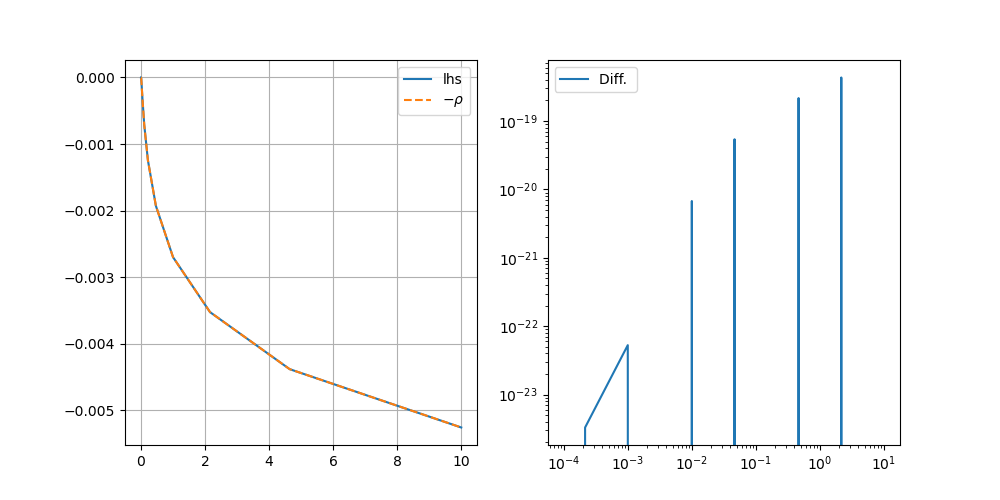

In [6]:
# Plotting

fig, ax = plt.subplots(1,2,figsize=(10, 5),sharex = False)

ax[0].plot(kmodes,lhs[:,0], label = "lhs")
ax[0].plot(kmodes,rhs[:,0], label = "$-\\rho$", linestyle = "dashed")

ax[0].grid()
ax[0].legend()

ax[1].loglog()
ax[1].plot(kmodes,np.abs(lhs[:,0] - rhs[:,0]), label = "Diff. ")
ax[1].legend()

plt.show()

### Testing expression for hprime

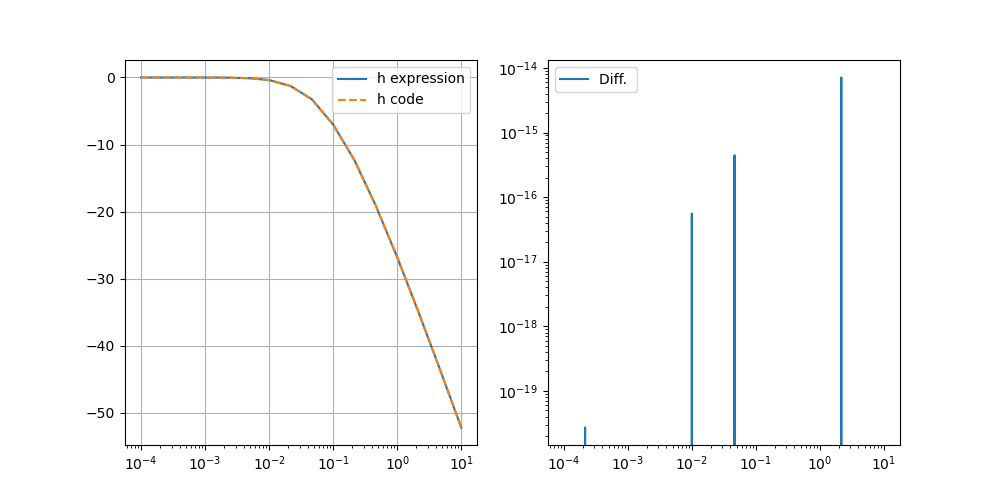

In [7]:
hprime_expr = np.zeros_like(eta)# (2.0 * kmodes**2 * eta + dgrho) / aprimeoa
for i in range(kmodes.shape[0]):
    hprime_expr[i,:] = (2.0 * kmodes[i]**2 * eta[i,:] + dgrho[i,:]) / aprimeoa[i,:]

fig, ax = plt.subplots(1,2,figsize=(10, 5),sharex = False)

ax[0].semilogx()
ax[0].plot(kmodes,hprime_expr[:,0], label = "h expression"                     )
ax[0].plot(kmodes,hprime[:,0],      label = "h code",      linestyle = "dashed")

ax[0].grid()
ax[0].legend()

ax[1].loglog()
ax[1].plot(kmodes,np.abs(hprime_expr[:,0]-hprime[:,0]), label = "Diff. ")
ax[1].legend()

plt.show()